# Non-Maximum Supression Validation


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark(cores=4)
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/03 18:02:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/03 18:02:27 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Sat May  3 06:02:29 PM EDT 2025


### NMS detections

In [5]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data"
detect_path = f"{data_path}/detection/test_2025/test_2025_detection_v1"
detection_df = spark.read.parquet(detect_path)
detection_df.printSchema()
detection_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- extracted_bbox: array (nullable = true)
 |    |    |-- element: binary (containsNull = true)
 |    |-- boxes: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: integer (containsNull = true)
 |    |-- scores: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- text_labels: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- sample_id: integer (nullable = true)



+--------------------+--------------------+---------+
|          image_name|              output|sample_id|
+--------------------+--------------------+---------+
|CBN-PdlC-D4-20160...|{[[89 50 4E 47 0D...|        0|
|CBN-Pla-A5-201407...|{[[89 50 4E 47 0D...|        0|
|CBN-PdlC-F4-20190...|{[[89 50 4E 47 0D...|        0|
|LISAH-BOU-0-167-2...|{[[89 50 4E 47 0D...|        0|
|CBN-Pla-A5-201409...|{[[89 50 4E 47 0D...|        0|
+--------------------+--------------------+---------+
only showing top 5 rows



In [6]:
detection_df.count()

2105

In [10]:
from pyspark.sql.functions import size, avg

avg_detections = (
    detection_df.select(size("output.extracted_bbox").alias("num_boxes"))
    .agg(avg("num_boxes"))
    .first()[0]
)
avg_detections

8.101187648456056

In [11]:
# Path and dataset names
test_path = f"{data_path}/parquet/test_2024"
test_df = spark.read.parquet(test_path)
test_df.printSchema()
test_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)



+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-PdlC-C6-20130...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-Pla-D3-201508...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C3-20190...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-C1-20200...|/test_2024/images...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B2-20160...|/test_2024/images...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [12]:
# join with test_df
joined_df = detection_df.join(test_df, on="image_name", how="inner")
joined_df.printSchema()
# get first imane name
image_name = joined_df.select("image_name").first()[0]
image_row = joined_df.filter(joined_df.image_name == image_name).collect()

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- extracted_bbox: array (nullable = true)
 |    |    |-- element: binary (containsNull = true)
 |    |-- boxes: array (nullable = true)
 |    |    |-- element: array (containsNull = true)
 |    |    |    |-- element: integer (containsNull = true)
 |    |-- scores: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- text_labels: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- sample_id: integer (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)



In [13]:
display(image_name)

'CBN-PdlC-A5-20130903.jpg'

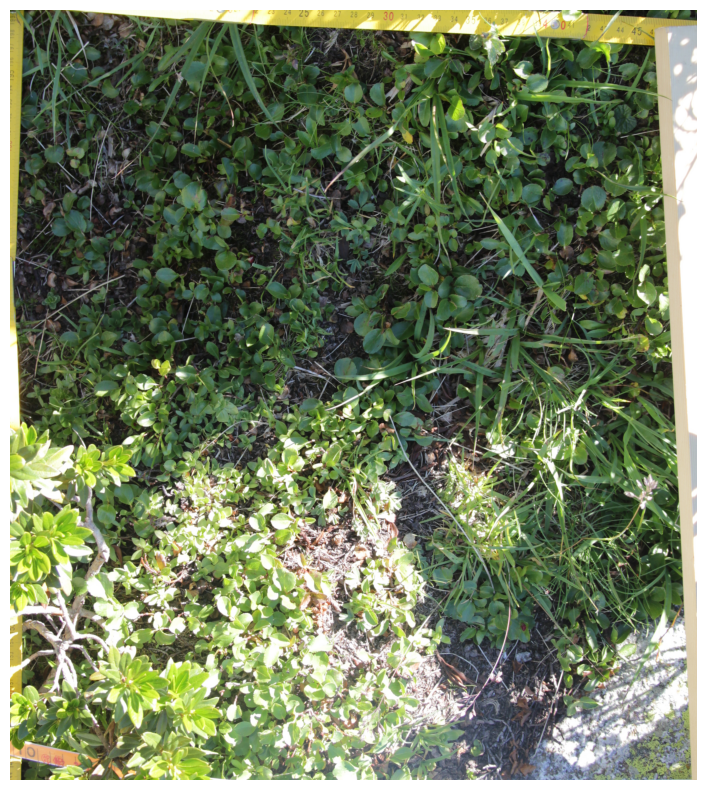

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from plantclef.serde import deserialize_image


# extract image
img_bytes = image_row[0]["data"]
np_arr = np.frombuffer(img_bytes, np.uint8)
img = deserialize_image(img_bytes)  # Pillow image

# plot Pillow image
plt.figure(figsize=(10, 10))
plt.imshow(img)  # img_rgb
plt.axis("off")
plt.show()

In [ ]:
import matplotlib.patches as patches


def plot_detections(image, detections):
    # assign colors to labels
    unique_labels = list(set(detections["text_labels"]))
    cmap = plt.get_cmap("tab10", len(unique_labels))
    label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

    # create a figure
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)  # Pillow image

    # loop through detections and draw boxes with corresponding label colors
    for box, label, score in zip(
        detections["boxes"], detections["text_labels"], detections["scores"]
    ):
        x_min, y_min, x_max, y_max = box
        color = label_to_color[label]

        # create a rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)

        # add label text
        ax.text(
            x_min,
            y_min - 5,
            f"{label} {score:.2f}",
            fontsize=12,
            color="white",
            bbox=dict(facecolor=color, edgecolor="none", pad=2.0),
        )

    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [16]:
detections = {
    "boxes": image_row[0]["output"]["boxes"],
    "text_labels": image_row[0]["output"]["text_labels"],
    "scores": image_row[0]["output"]["scores"],
}

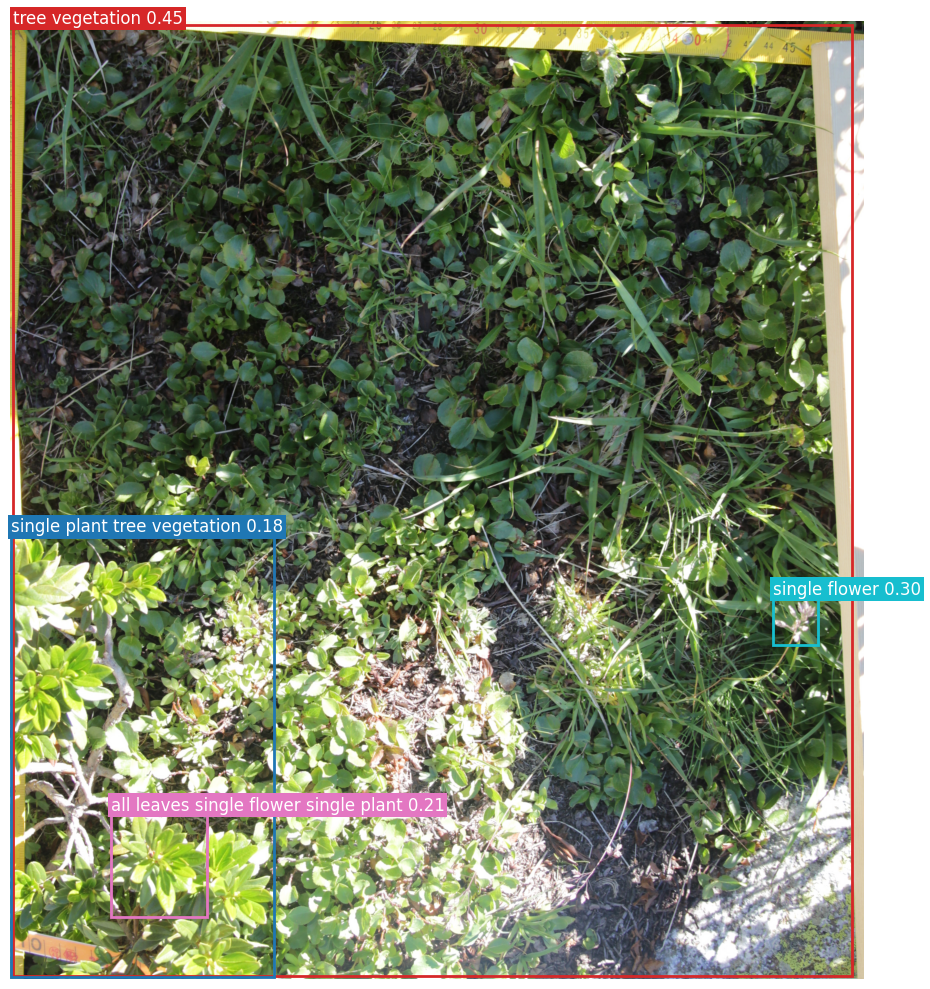

In [17]:
plot_detections(image=img, detections=detections)

In [18]:
len(detections["boxes"]), len(detections["text_labels"]), len(detections["scores"])

(4, 4, 4)

In [19]:
detections["text_labels"]

['tree vegetation',
 'single flower',
 'all leaves single flower single plant',
 'single plant tree vegetation']

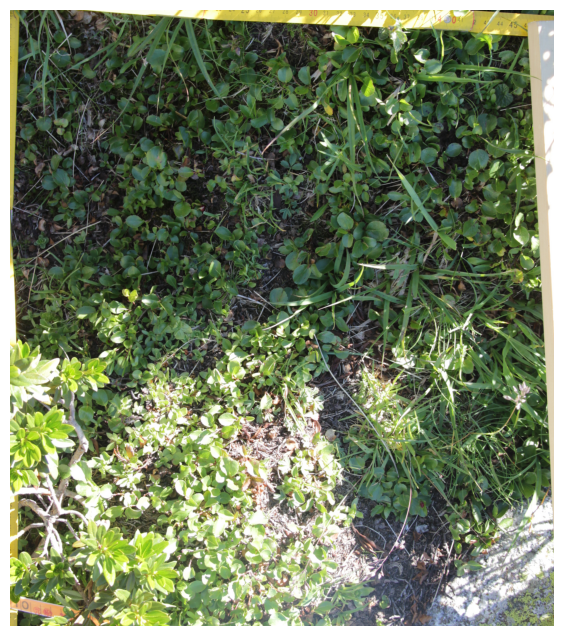

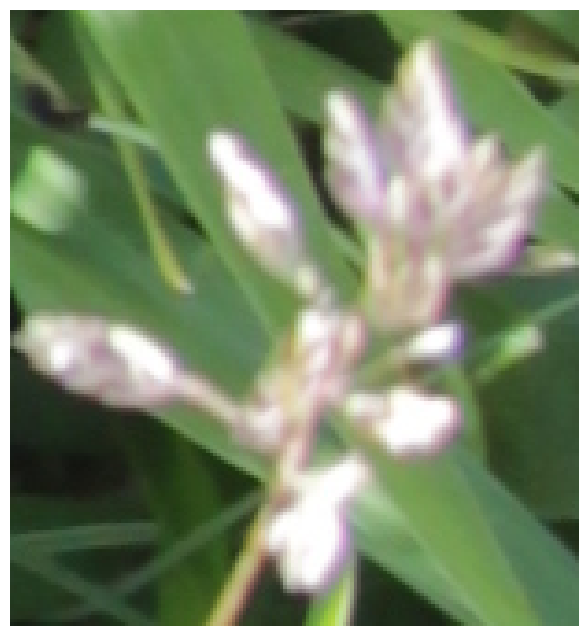

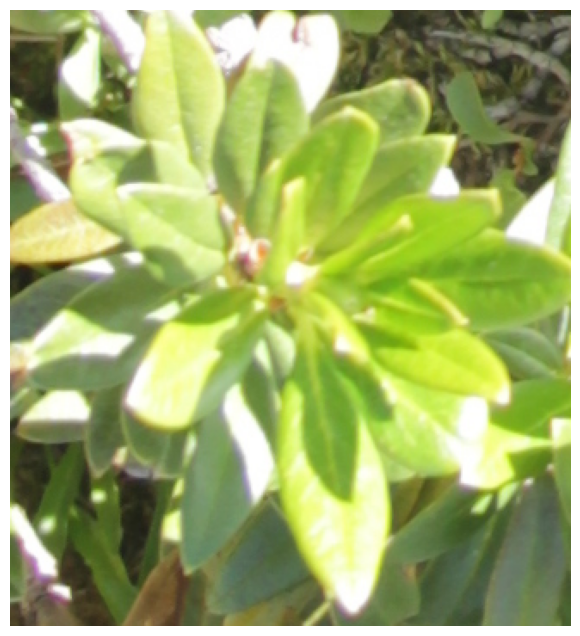

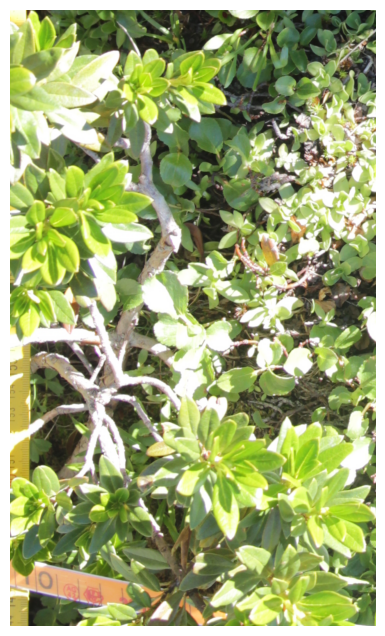

In [20]:
from plantclef.serde import deserialize_image

bboxes = image_row[0]["output"]["extracted_bbox"]
for i in range(len(bboxes)):
    bbox = bboxes[i]
    img_bbox = deserialize_image(bbox)
    # plot Pillow image
    plt.figure(figsize=(8, 8))
    plt.imshow(img_bbox)  # img_rgb
    plt.axis("off")
    plt.show()